In [1]:
from PIL import Image, ImageOps
from importTDP_lib import *

In [11]:
def load_image(img_path):
    img = Image.open(img_path)
    img = ImageOps.contain(img, (224,224), Image.Resampling.LANCZOS).convert("RGB")
    img = ImageOps.autocontrast(img)
    img = Image.fromarray(np.array(img))
    # img = ImageOps.pad(img, (224,224), centering=(0,0))

    return img

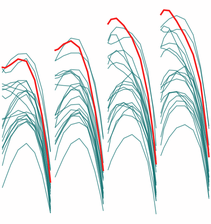

In [12]:
img_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\temp_classify\other_recovery\2GH771MS_0.png"
img = load_image(img_path)
img

In [17]:
from datasets import load_dataset, DatasetDict

In [14]:
dataset = load_dataset("imagefolder", data_dir=r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\temp_classify")

Resolving data files:   0%|          | 0/606 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
train_test_valid = dataset["train"].train_test_split(test_size=0.2)
test_valid = train_test_valid["test"].train_test_split(test_size=0.5)
ds = DatasetDict({
    "train": train_test_valid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]
})

In [19]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 484
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 61
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 61
    })
})

In [20]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

labels = ds["train"].features["label"].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    label2id={label: i for i, label in enumerate(labels)},
    id2label={i: label for i, label in enumerate(labels)},
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
labels

['high_recovery', 'low_recovery', 'other_recovery']

In [22]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [23]:
def process_example(example):
    example["image"] = example["image"]
    inputs = feature_extractor(example["image"], return_tensors="pt")
    inputs["labels"] = example["label"]
    return inputs

In [24]:
def _transform(example_batch):
    IMG_SIZE = 224
    new_imgs = []
    for img in example_batch["image"]:
        img = Image.fromarray(img.numpy())
        img = ImageOps.contain(img, (IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS).convert("RGB")
        img = ImageOps.autocontrast(img)
        img = Image.fromarray(np.array(img))
        new_imgs.append(img)
    return new_imgs

def transform(example_batch):
    inputs = feature_extractor([x for x in _transform(example_batch)], return_tensors="pt")
    inputs["labels"] = example_batch["label"]
    return inputs

In [25]:
prepared_data = ds.with_transform(transform)

In [26]:
from datasets import load_metric

In [27]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


acc = load_metric("accuracy")
f1 = load_metric("f1")

def compute_metrics(p):
    info = {}

    preds = np.argmax(p.predictions, axis=1)
    info["accuracy"] = acc.compute(predictions=preds, references=p.label_ids)["accuracy"]
    info["f1"] = f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]

    return info

In [34]:
from transformers import TrainingArguments

os.makedirs("./vit-tdp", exist_ok=True)
training_args = TrainingArguments(
  output_dir="code/cnn_trainer_v0.2.1/vit-tdp",
  per_device_train_batch_size=64,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=20,
  fp16=False,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  warmup_ratio=0.05,
  remove_unused_columns=False,
  push_to_hub=False,
  metric_for_best_model="f1",
  report_to='tensorboard',
  load_best_model_at_end=True,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [33]:
!pip install transformers[torch]


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip
